In [1]:
import pandas as pd
from preprocess import Audio_Processor
import data_utils as du
from sklearn import metrics
from keras.wrappers.scikit_learn import KerasClassifier
from classification_plots import plot_confusion_matrix, plot_learning_curve
import matplotlib.pyplot as plt
import os
import mdn

Using TensorFlow backend.


In [2]:
# Able to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="1"

SR = 44100
blocksize = 11025
overlap = 5512

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Setup

In [4]:
audio_dir = '../ESC-50/audio/'

In [5]:
path_to_db='../ESC-50/'
ps = Audio_Processor(path_to_db + 'audio/')

# Load Dataset
Here we load the csv that describes each file in the dataset. We add a high level category that is defined in the ESC-50 documentation. This we realize is anthetical to true training, it is a stopgap for when we use NLP to classify tags into these categories.

In [6]:
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')
classes = [None] * 50
h_classes = ['Human & Animal', 'Interacting Materials']

In [7]:
mapping = {
    'dog': 0,
    'rooster': 0,
    'pig': 0,
    'cow': 0,
    'frog': 0,
    'cat': 0,
    'hen': 0,
    'insects': 0,
    'sheep': 0,
    'crow': 0,
    'rain': 1,
    'sea_waves': 1,
    'crackling_fire': 1,
    'crickets': 0,
    'chirping_birds': 0,
    'water_drops': 1,
    'wind': 1,
    'pouring_water': 1,
    'toilet_flush': 1,
    'thunderstorm': 1,
    'crying_baby': 0,
    'sneezing': 0,
    'clapping': 0,
    'breathing': 0,
    'coughing': 0,
    'footsteps': 1,
    'laughing': 0,
    'brushing_teeth': 1,
    'snoring': 0,
    'drinking_sipping': 1,
    'door_wood_knock': 1,
    'mouse_click': 1,
    'keyboard_typing': 1,
    'door_wood_creaks': 1,
    'can_opening': 1,
    'washing_machine': 1,
    'vacuum_cleaner': 1,
    'clock_alarm': 1,
    'clock_tick': 1,
    'glass_breaking':1 ,
    'helicopter': 1,
    'chainsaw': 1,
    'siren': 1,
    'car_horn': 1,
    'engine': 1,
    'train': 1,
    'church_bells': 1,
    'airplane': 1,
    'fireworks': 1,
    'hand_saw': 1,
}

In [8]:
dataset['h_category'] = None
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']
    dataset.loc[index, 'h_category'] = mapping[row['category']]

In [9]:
dataset.head()

,filename,fold,target,category,esc10,src_file,take,h_category
0,1-100032-A-0.wav,1,0,dog,True,100032,A,0
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A,0
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A,1
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B,1
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A,1


## Getting Preprocessed Data
We allow for previously preprocessed data to be retrieved for faster training turnaround. If the fold has been preprocessed, it is loaded but if not it is processed and saved.

In [10]:
import time
import librosa
import numpy as np
import soundfile as sf

def load_fold_audio_blockwise(fld, data, blocksize=1024, overlap=512, debug=False):
    start_time = time.time()
    f_df = data[data['fold'] == fld]
    items = []
    h_cat = []
    cat = []
    for i, sample in f_df.iterrows():
        if debug:
            print("File Processing", end="", flush=True)
        blockgen = sf.blocks(audio_dir + sample['filename'], 
                             blocksize=blocksize, 
                             overlap=overlap, 
                             always_2d=True, 
                             fill_value=0.0)
        SR = sf.info(audio_dir + sample['filename']).samplerate
        for bl in blockgen:
            if not np.any(bl):
                continue
            if debug:
                print(".", end="", flush=True)
            y = bl.transpose()
            y = y[:int(blocksize)]
            y = y[np.newaxis, :]
            items.append(y)
            h_cat.append(sample.h_category)
            cat.append(sample.target)
        if debug:
            print("Done")

    print("\tProcessing Time: " + str(time.time() - start_time))
    return np.vstack(items), np.array(h_cat), np.array(cat)

def load_audio_blockwise(data, blocksize=1024, overlap=512, debug=False):
    start_time = time.time()
    items = []
    target = []
    for i, sample in data.iterrows():
        if debug:
            print("File Processing", end="", flush=True)
        blockgen = sf.blocks(audio_dir + sample['filename'], 
                             blocksize=blocksize, 
                             overlap=overlap, 
                             always_2d=True, 
                             fill_value=0.0)
        sr = sf.info(audio_dir + sample['filename']).samplerate
        for bl in blockgen:
            if not np.any(bl):
                continue
            if debug:
                print(".", end="", flush=True)
            y = bl.transpose()
            y = y[:int(blocksize)]
            y = y[np.newaxis, :]
            items.append(y)
            target.append(sample.h_category)
        if debug:
            print("Done")
    print("\tProcessing Time: " + str(time.time() - start_time))
    return np.vstack(items), np.array(target)

In [11]:
c_data, targets, c_targets = load_fold_audio_blockwise(1, dataset, blocksize, overlap)
# c_data, targets = load_fold_audio(1, dataset)
print(c_data.shape)

	Processing Time: 5.926394701004028
(14019, 1, 11025)


In [12]:
a_data = c_data[targets == 0]
a_targ = c_targets[targets == 0]
i_data = c_data[targets == 1]
i_targ = c_targets[targets == 1]

In [13]:
names_a = []
for name in np.unique(a_targ):
    names_a.append(classes[name])
names_i = []
for name in np.unique(i_targ):
    names_i.append(classes[name])
print(names_a)
print(names_i)

['dog', 'rooster', 'pig', 'cow', 'frog', 'cat', 'hen', 'insects', 'sheep', 'crow', 'crickets', 'chirping_birds', 'crying_baby', 'sneezing', 'clapping', 'breathing', 'coughing', 'laughing', 'snoring']
['rain', 'sea_waves', 'crackling_fire', 'water_drops', 'wind', 'pouring_water', 'toilet_flush', 'thunderstorm', 'footsteps', 'brushing_teeth', 'drinking_sipping', 'door_wood_knock', 'mouse_click', 'keyboard_typing', 'door_wood_creaks', 'can_opening', 'washing_machine', 'vacuum_cleaner', 'clock_alarm', 'clock_tick', 'glass_breaking', 'helicopter', 'chainsaw', 'siren', 'car_horn', 'engine', 'train', 'church_bells', 'airplane', 'fireworks', 'hand_saw']


In [14]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(
                        c_data, targets, test_size=0.20, random_state=42)

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import keras
import kapre
from datetime import datetime
now = datetime.now()
import librosa
from librosa import display

def check_model(model):
    model.summary(line_length=80, positions=[.33, .65, .8, 1.])

    batch_input_shape = (2,) + model.input_shape[1:]
    batch_output_shape = (2,) + model.output_shape[1:]
    model.compile('sgd', 'mse')
    model.fit(np.random.uniform(size=batch_input_shape), np.random.uniform(size=batch_output_shape), epochs=1)

def visualise_model(model, src, logam=False):
    n_ch, nsp_src = model.input_shape[1:]
    print(src.shape)
    src = src[:nsp_src]
    src_batch = src[np.newaxis, :]
    pred = model.predict(x=src_batch)
    if keras.backend.image_data_format == 'channels_first':
        result = pred[0, 0]
    else:
        result = pred[0, :, :, 0]
    display.specshow(result, y_axis='linear', fmin=800, fmax=8000, sr=SR)
    plt.show()
    
def evaluate_model(model, c_data):
    pred = model.predict(x=c_data)
    if keras.backend.image_data_format == 'channels_first':
        result = pred[0, 0]
    else:
        result = pred[:, :, :, 0]
#     result = np.swapaxes(result, 1, 2)
    print(result.shape)
    return result

________________________________________________________________________________
Layer (type)              Output Shape              Param #     
melspectrogram_1 (Melspec (None, 128, 44, 1)        296064      
Total params: 296,064
Trainable params: 0
Non-trainable params: 296,064
________________________________________________________________________________
Epoch 1/1
2/2 [==============================] - 5s 2s/step - loss: 1417.3806
(1, 11025)


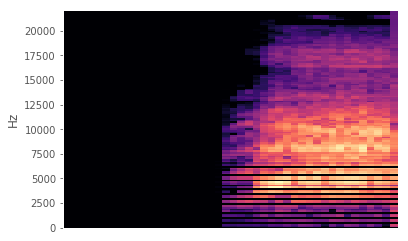

(14019, 128, 44)
________________________________________________________________________________
Layer (type)              Output Shape              Param #     
spectrogram_1 (Spectrogra (None, 257, 44, 1)        263168      
Total params: 263,168
Trainable params: 0
Non-trainable params: 263,168
________________________________________________________________________________
Epoch 1/1
2/2 [==============================] - 0s 81ms/step - loss: 1180.1519
(1, 11025)


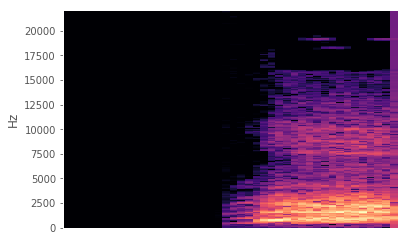

(14019, 257, 44)


In [16]:
import keras
import kapre
from keras.models import Sequential
from kapre.time_frequency import Melspectrogram, Spectrogram
from kapre.filterbank import Filterbank
import numpy as np

model = Sequential()
model.add(Melspectrogram(
    sr=44100,
    n_mels=128,
    power_melgram=2.0,
    return_decibel_melgram = True,
    input_shape=(1, blocksize),
    trainable_fb=False
))

check_model(model)
visualise_model(model, c_data[1])
mfccs = evaluate_model(model, c_data)

model = Sequential()
model.add(Spectrogram(
    return_decibel_spectrogram = True,
    input_shape=(1, blocksize)
))

check_model(model)
visualise_model(model, c_data[1])
spec = evaluate_model(model, c_data)

# Deep Net
Separate into classes

In [17]:
import librosa

def preprocess(mel_spec, spec):
    # Calculate the first 13 mfcc's
    mfccs = librosa.feature.mfcc(S=mel_spec, n_mfcc=13)
    # Get first derivative of the mfccs
    delta = librosa.feature.delta(mfccs)
    # Get second derivative of mfccs
    delta_2 = librosa.feature.delta(mfccs, order=2)
    
    spec_contrast = librosa.feature.spectral_contrast(S=spec)
    
    return np.vstack((mfccs[1:], delta, delta_2, spec_contrast)).transpose()

In [18]:
a_mfcc = mfccs[targets == 0]
a_spec = spec[targets == 0]
a_targ = c_targets[targets == 0]
i_mfcc = mfccs[targets == 1]
i_spec = spec[targets == 1]
i_targ = c_targets[targets == 1]

In [19]:
start_time = time.time()

new_dat = []
for i in range(0, a_spec.shape[0]):
    new_dat.append(preprocess(a_mfcc[i], a_spec[i]))

print(new_dat[0].shape)
print("\tProcessing Time: " + str(time.time() - start_time))

(44, 45)
	Processing Time: 30.583728075027466


In [20]:
new_dat = np.average(new_dat, axis=1)
print(new_dat.shape)

(5171, 45)


In [21]:
new_dat = np.vstack(new_dat)
print(new_dat.shape)

(5171, 45)


In [22]:
print(a_targ.shape)

(5171,)


# Animal Sounds

In [23]:
train_X, test_X, train_y, test_y = train_test_split(
                        new_dat, a_targ, test_size=0.20, random_state=56)

In [24]:
from keras.layers import Dense, Dropout

def gpu_mfcc_deep_net_a():
    # Create Model
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(45,)))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(19, kernel_initializer='normal', activation='softmax'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    model.summary()

    
    return model

In [25]:
anim = KerasClassifier(build_fn=gpu_mfcc_deep_net_a, 
                       epochs=200, 
                       batch_size=128, 
                       validation_split=0.15)
history = anim.fit(train_X, train_y)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               5888      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
__________

3515/3515 [==============================] - 0s 82us/step - loss: 0.6195 - acc: 0.8060 - val_loss: 0.4744 - val_acc: 0.8583
Epoch 49/200
3515/3515 [==============================] - 0s 98us/step - loss: 0.6112 - acc: 0.8040 - val_loss: 0.4913 - val_acc: 0.8519
Epoch 50/200
3515/3515 [==============================] - 0s 80us/step - loss: 0.6291 - acc: 0.7989 - val_loss: 0.5036 - val_acc: 0.8454
Epoch 51/200
3515/3515 [==============================] - 0s 81us/step - loss: 0.5939 - acc: 0.8105 - val_loss: 0.4741 - val_acc: 0.8470
Epoch 52/200
3515/3515 [==============================] - 0s 77us/step - loss: 0.5662 - acc: 0.8156 - val_loss: 0.4707 - val_acc: 0.8502
Epoch 53/200
3515/3515 [==============================] - 0s 75us/step - loss: 0.5622 - acc: 0.8174 - val_loss: 0.4576 - val_acc: 0.8615
Epoch 54/200
3515/3515 [==============================] - 0s 75us/step - loss: 0.5494 - acc: 0.8270 - val_loss: 0.4599 - val_acc: 0.8599
Epoch 55/200
3515/3515 [==============================

Epoch 108/200
3515/3515 [==============================] - 0s 88us/step - loss: 0.3057 - acc: 0.9053 - val_loss: 0.3552 - val_acc: 0.8969
Epoch 109/200
3515/3515 [==============================] - 0s 75us/step - loss: 0.3133 - acc: 0.9021 - val_loss: 0.3729 - val_acc: 0.8873
Epoch 110/200
3515/3515 [==============================] - 0s 75us/step - loss: 0.3159 - acc: 0.9007 - val_loss: 0.3491 - val_acc: 0.8921
Epoch 111/200
3515/3515 [==============================] - 0s 77us/step - loss: 0.3028 - acc: 0.9050 - val_loss: 0.3486 - val_acc: 0.8986
Epoch 112/200
3515/3515 [==============================] - 0s 81us/step - loss: 0.3325 - acc: 0.8964 - val_loss: 0.3680 - val_acc: 0.8873
Epoch 113/200
3515/3515 [==============================] - 0s 106us/step - loss: 0.3025 - acc: 0.9030 - val_loss: 0.3745 - val_acc: 0.8937
Epoch 114/200
3515/3515 [==============================] - 0s 78us/step - loss: 0.3056 - acc: 0.9024 - val_loss: 0.3740 - val_acc: 0.8889
Epoch 115/200
3515/3515 [========

3515/3515 [==============================] - 0s 77us/step - loss: 0.2297 - acc: 0.9292 - val_loss: 0.3579 - val_acc: 0.9050
Epoch 168/200
3515/3515 [==============================] - 0s 77us/step - loss: 0.2381 - acc: 0.9289 - val_loss: 0.3637 - val_acc: 0.8969
Epoch 169/200
3515/3515 [==============================] - 0s 78us/step - loss: 0.2307 - acc: 0.9249 - val_loss: 0.3880 - val_acc: 0.9098
Epoch 170/200
3515/3515 [==============================] - 0s 74us/step - loss: 0.2430 - acc: 0.9235 - val_loss: 0.3516 - val_acc: 0.9147
Epoch 171/200
3515/3515 [==============================] - 0s 73us/step - loss: 0.2673 - acc: 0.9218 - val_loss: 0.3433 - val_acc: 0.9050
Epoch 172/200
3515/3515 [==============================] - 0s 81us/step - loss: 0.2266 - acc: 0.9283 - val_loss: 0.3811 - val_acc: 0.8986
Epoch 173/200
3515/3515 [==============================] - 0s 93us/step - loss: 0.2139 - acc: 0.9351 - val_loss: 0.3630 - val_acc: 0.9034
Epoch 174/200
3515/3515 [=======================

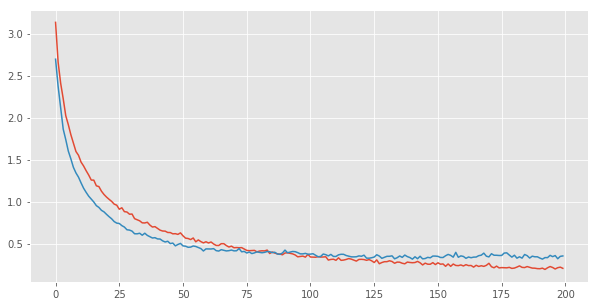

In [26]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

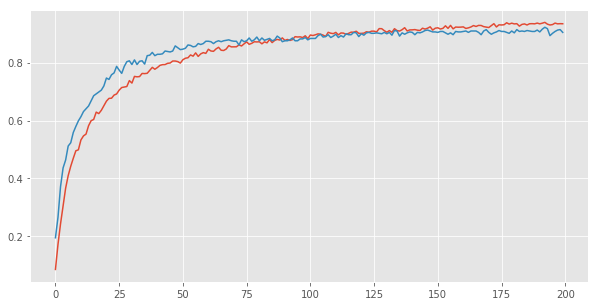

In [27]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

0.9140096618357488
Confusion matrix, without normalization
[[51  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0]
 [ 4 34  0  1  0  0  1  0  0  1  0  0  0  1  0  0  0  0  0]
 [ 0  0 54  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0 52  2  0  0  0  1  0  0  0  4  2  1  0  0  1  0]
 [ 0  0  0  0 47  0  0  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 0  1  0  0  1 43  1  0  0  0  0  0  0  2  0  0  0  0  1]
 [ 0  0  0  0  0  0 56  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 47  0  0  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  1  0  0  2  0 74  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 58  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 72  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 59  0  0  0  0  1  0  2]
 [ 0  0  0  1  3  2  0  0  0  0  0  0 50  2  0  0  1  0  0]
 [ 0  0  0  1  1  0  0  1  0  0  0  1  0 18  0  1  1  1  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 58  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 

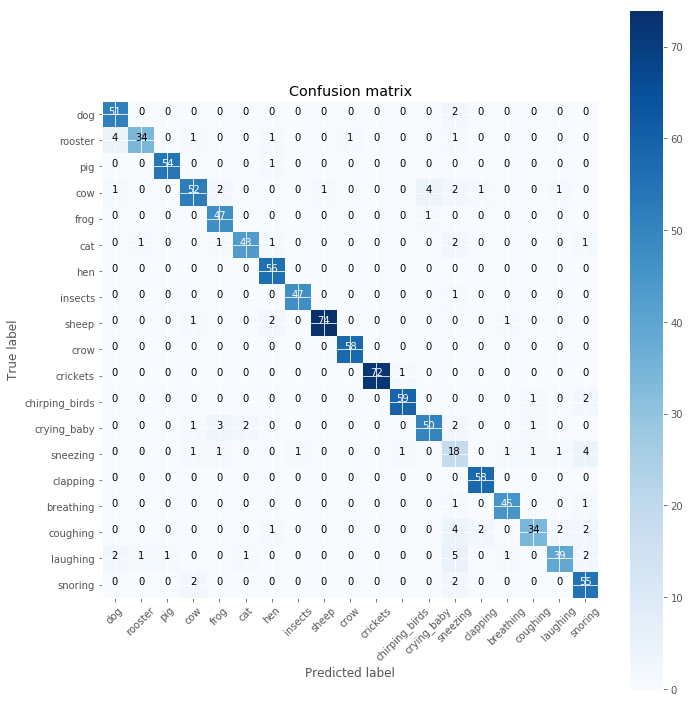

In [28]:
pred = anim.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, names_a)
plt.show()

# Interacting Materials

In [29]:
start_time = time.time()

new_dat = []
for i in range(0, i_spec.shape[0]):
    new_dat.append(preprocess(i_mfcc[i], i_spec[i]))

print(new_dat[0].shape)
print("\tProcessing Time: " + str(time.time() - start_time))

(44, 45)
	Processing Time: 51.21092987060547


In [30]:
new_dat = np.average(new_dat, axis=1)
print(new_dat.shape)

(8848, 45)


In [31]:
print(i_targ.shape)

(8848,)


In [32]:
train_X, test_X, train_y, test_y = train_test_split(
                        new_dat, i_targ, test_size=0.20, random_state=75)

In [33]:
def gpu_mfcc_deep_net_i():
    # Create Model
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(45,)))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(31, kernel_initializer='normal', activation='softmax'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    model.summary()

    
    return model

In [34]:
inter = KerasClassifier(build_fn=gpu_mfcc_deep_net_i, epochs=200, batch_size=128, validation_split=0.15)
history = inter.fit(train_X, train_y)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 128)               5888      
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
__________

6016/6016 [==============================] - 0s 75us/step - loss: 0.7480 - acc: 0.7758 - val_loss: 0.5965 - val_acc: 0.8305
Epoch 49/200
6016/6016 [==============================] - 0s 74us/step - loss: 0.7092 - acc: 0.7753 - val_loss: 0.5755 - val_acc: 0.8399
Epoch 50/200
6016/6016 [==============================] - 0s 78us/step - loss: 0.7357 - acc: 0.7731 - val_loss: 0.5809 - val_acc: 0.8427
Epoch 51/200
6016/6016 [==============================] - 0s 78us/step - loss: 0.7231 - acc: 0.7736 - val_loss: 0.5637 - val_acc: 0.8446
Epoch 52/200
6016/6016 [==============================] - 1s 84us/step - loss: 0.7171 - acc: 0.7812 - val_loss: 0.5693 - val_acc: 0.8352
Epoch 53/200
6016/6016 [==============================] - 0s 75us/step - loss: 0.7055 - acc: 0.7804 - val_loss: 0.5524 - val_acc: 0.8540
Epoch 54/200
6016/6016 [==============================] - 0s 75us/step - loss: 0.6892 - acc: 0.7806 - val_loss: 0.5408 - val_acc: 0.8484
Epoch 55/200
6016/6016 [==============================

Epoch 108/200
6016/6016 [==============================] - 0s 73us/step - loss: 0.4608 - acc: 0.8587 - val_loss: 0.4113 - val_acc: 0.8851
Epoch 109/200
6016/6016 [==============================] - 0s 72us/step - loss: 0.4437 - acc: 0.8684 - val_loss: 0.4172 - val_acc: 0.8945
Epoch 110/200
6016/6016 [==============================] - 0s 72us/step - loss: 0.4362 - acc: 0.8634 - val_loss: 0.4261 - val_acc: 0.8861
Epoch 111/200
6016/6016 [==============================] - 0s 77us/step - loss: 0.4611 - acc: 0.8630 - val_loss: 0.3984 - val_acc: 0.8974
Epoch 112/200
6016/6016 [==============================] - 0s 73us/step - loss: 0.4123 - acc: 0.8748 - val_loss: 0.4106 - val_acc: 0.8908
Epoch 113/200
6016/6016 [==============================] - 0s 70us/step - loss: 0.4401 - acc: 0.8680 - val_loss: 0.4057 - val_acc: 0.8898
Epoch 114/200
6016/6016 [==============================] - 0s 67us/step - loss: 0.4491 - acc: 0.8652 - val_loss: 0.4234 - val_acc: 0.8908
Epoch 115/200
6016/6016 [=========

6016/6016 [==============================] - 0s 67us/step - loss: 0.3465 - acc: 0.8891 - val_loss: 0.3719 - val_acc: 0.9040
Epoch 168/200
6016/6016 [==============================] - 0s 77us/step - loss: 0.3723 - acc: 0.8878 - val_loss: 0.3732 - val_acc: 0.9087
Epoch 169/200
6016/6016 [==============================] - 1s 87us/step - loss: 0.3583 - acc: 0.8880 - val_loss: 0.4028 - val_acc: 0.8992
Epoch 170/200
6016/6016 [==============================] - 0s 69us/step - loss: 0.3663 - acc: 0.8920 - val_loss: 0.3933 - val_acc: 0.9030
Epoch 171/200
6016/6016 [==============================] - 0s 71us/step - loss: 0.3546 - acc: 0.8938 - val_loss: 0.3729 - val_acc: 0.9030
Epoch 172/200
6016/6016 [==============================] - 0s 74us/step - loss: 0.3601 - acc: 0.8939 - val_loss: 0.3843 - val_acc: 0.9040
Epoch 173/200
6016/6016 [==============================] - 0s 68us/step - loss: 0.3559 - acc: 0.8911 - val_loss: 0.3852 - val_acc: 0.9096
Epoch 174/200
6016/6016 [=======================

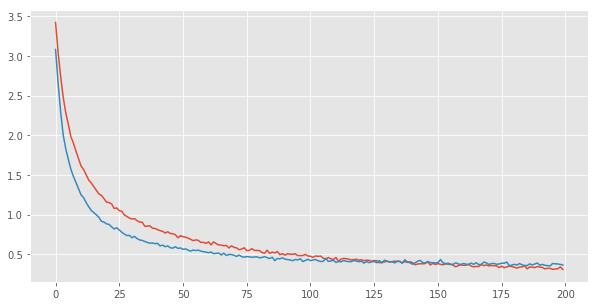

In [35]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

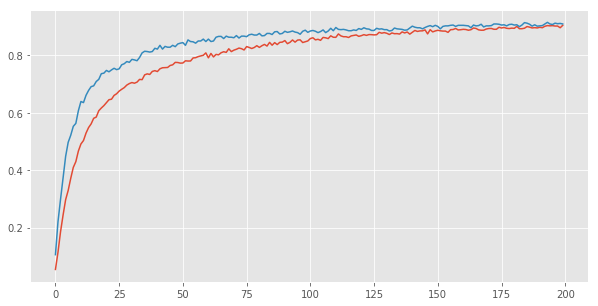

In [36]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

0.9152542372881356
Confusion matrix, without normalization
[[57  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0 61  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0 58  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0 43  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  1  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0  0 69  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0  0  0 36  1  0  0  0  0  0  0  0  1  3  0  0  1  0  1  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 47  0  0  0  1  0  0  0  0  0  0  1  1  0  1  0  0  0
   0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0 57  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0
   0  0  2  0  0  1  0]
 [ 0  0  0  0  1  1  1  0 43  0  1  0  0  1  0  0  0  0  0  0  0  0  1  0
   0  0  0  0  0  2  0]
 [ 0  0  0  1  0  0  0  0  0 58  2  0  0  0  0  0  0  0  0 

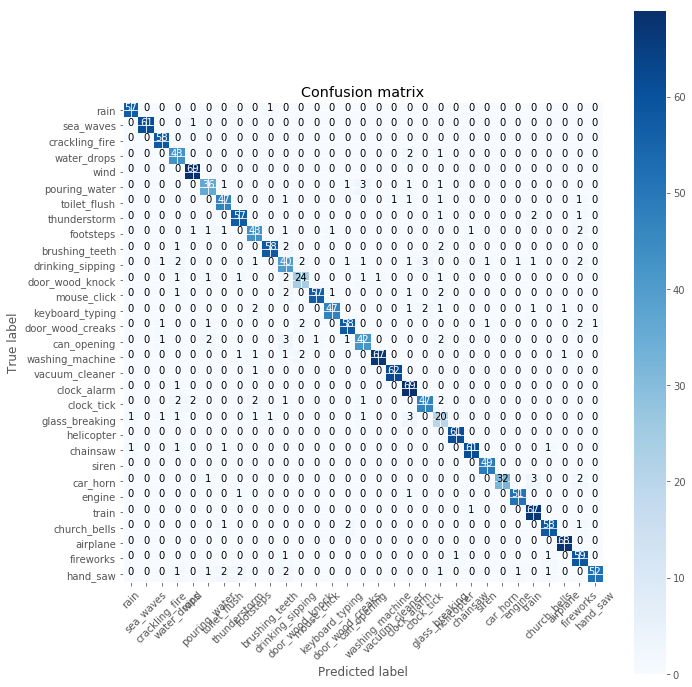

In [37]:
pred = inter.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, names_i)
plt.show()

# All Data

In [38]:
X2, y2, yy2 = load_fold_audio_blockwise(2, dataset, blocksize, overlap)
X3, y3, yy3 = load_fold_audio_blockwise(3, dataset, blocksize, overlap)
X4, y4, yy4 = load_fold_audio_blockwise(4, dataset, blocksize, overlap)
X5, y5, yy5 = load_fold_audio_blockwise(5, dataset, blocksize, overlap)

	Processing Time: 6.259936332702637
	Processing Time: 5.737609148025513
	Processing Time: 5.917178630828857
	Processing Time: 6.020036697387695


In [39]:
X = np.vstack((X2, X3, X4, X5))
print(X.shape)

(56774, 1, 11025)


In [40]:
y = np.concatenate((y2, y3, y4, y5))
print(y.shape)

(56774,)


In [41]:
yy = np.concatenate((yy2, yy3, yy4, yy5))
print(yy.shape)

(56774,)


________________________________________________________________________________
Layer (type)              Output Shape              Param #     
melspectrogram_2 (Melspec (None, 128, 44, 1)        296064      
Total params: 296,064
Trainable params: 0
Non-trainable params: 296,064
________________________________________________________________________________
Epoch 1/1
2/2 [==============================] - 1s 252ms/step - loss: 1429.6451
(1, 11025)


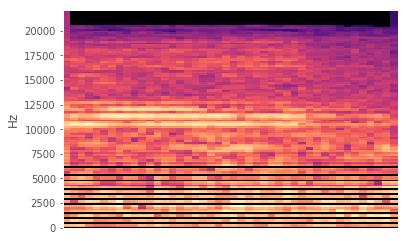

(56774, 128, 44)
________________________________________________________________________________
Layer (type)              Output Shape              Param #     
spectrogram_2 (Spectrogra (None, 257, 44, 1)        263168      
Total params: 263,168
Trainable params: 0
Non-trainable params: 263,168
________________________________________________________________________________
Epoch 1/1
2/2 [==============================] - 0s 247ms/step - loss: 1176.0115
(1, 11025)


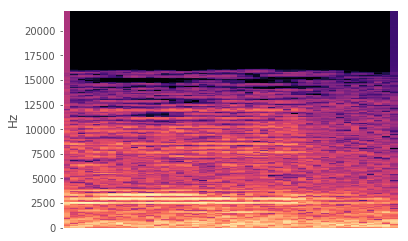

(56774, 257, 44)


In [42]:
model = Sequential()
model.add(Melspectrogram(
    sr=44100,
    n_mels=128,
    power_melgram=2.0,
    return_decibel_melgram = True,
    input_shape=(1, blocksize),
    trainable_fb=False
))

check_model(model)
visualise_model(model, X[1])
mfccs = evaluate_model(model, X)

model = Sequential()
model.add(Spectrogram(
    return_decibel_spectrogram = True,
    input_shape=(1, blocksize)
))

check_model(model)
visualise_model(model, X[1])
spec = evaluate_model(model, X)

In [43]:
a_mfcc = mfccs[y == 0]
a_spec = spec[y == 0]
a_targ = yy[y == 0]
i_mfcc = mfccs[y == 1]
i_spec = spec[y == 1]
i_targ = yy[y == 1]

In [44]:
start_time = time.time()

new_dat = []
for i in range(0, a_spec.shape[0]):
    new_dat.append(preprocess(a_mfcc[i], a_spec[i]))

print(new_dat[0].shape)
print("\tProcessing Time: " + str(time.time() - start_time))

start_time = time.time()

(44, 45)
	Processing Time: 129.8614592552185


In [45]:
new_dat = np.average(new_dat, axis=1)
print(new_dat.shape)

(21104, 45)


In [46]:
print(a_targ.shape)

(21104,)


0.2799943138741471
Confusion matrix, without normalization
[[561  30   0  34   6  32  76   1   7  21   4  18  89 113   9   8  39  41
   18]
 [177 264   1  58  25  13  17   6  12  67   7   6  24 135  12   0  22  24
   15]
 [  8   6 290  48   5  80  42  18  53  30   8 166  48  16   6  21  36 121
   74]
 [107   2  23 244 105  16 151  23 156  14   5   7  39  43  13  25  38  72
   30]
 [ 98  24   2   9 625  46  12   0  48  13   0  42 129  30  14   4  26 104
   18]
 [167  55  18  48  61  35  59  12  48  91   2  17  94  61  32  15  47  93
   74]
 [145  10  20  44  16  48 285 103  20   2  52  27 151  30  18  34  19  69
   60]
 [ 47  13  14  56   3   2  49 402  25   5  94  61   6  30   1   1   2  31
  369]
 [ 91  48  68  24  28  79  94  15 405  26   7  26  43  50  70  55  49  29
   27]
 [110  39  16  65 143  48  45  67  50 271   5  20  22   7  96  10  35  72
   16]
 [  0  17   2  25   1  25   0  36   3  63 260 383  76 196   0   4  23  25
  109]
 [ 62  48  30  14  23  33  38  68  24  25  96 416 

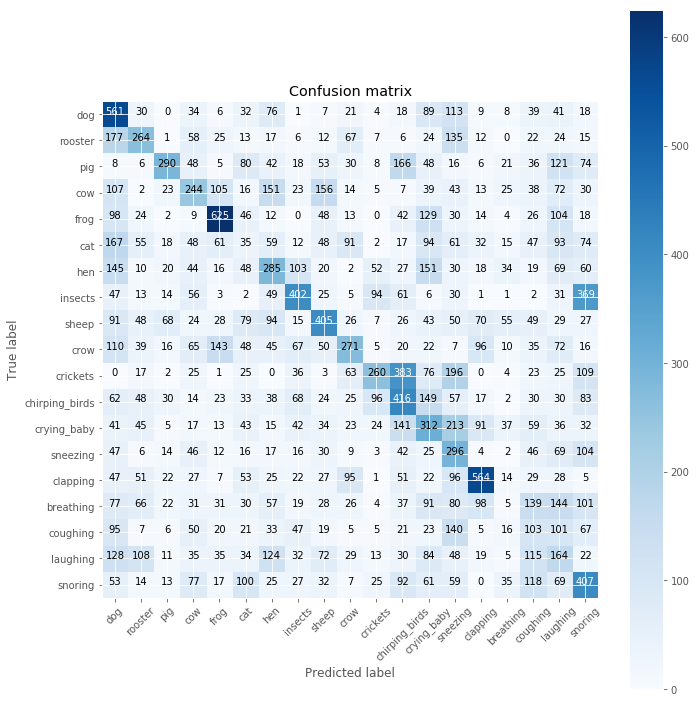

In [47]:
pred = anim.predict(new_dat)
print(metrics.accuracy_score(a_targ, pred))
cm = metrics.confusion_matrix(a_targ, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, names_a)
plt.show()

In [48]:
start_time = time.time()

new_dat = []
for i in range(0, i_spec.shape[0]):
    new_dat.append(preprocess(i_mfcc[i], i_spec[i]))

print(new_dat[0].shape)
print("\tProcessing Time: " + str(time.time() - start_time))

start_time = time.time()

(44, 45)
	Processing Time: 226.58593606948853


In [49]:
new_dat = np.average(new_dat, axis=1)
print(new_dat.shape)

(35670, 45)


In [50]:
print(i_targ.shape)

(35670,)


0.18912251191477433
Confusion matrix, without normalization
[[133  67   4   0  20  11  23   1   1 100   0   0   0   6  16  38  52   6
    3  15  12  69 401   0   2  67  23   0  30  17 131]
 [ 10 160  18   4 155  12  71   0  29   0   2   0   4   3  43   0   6   5
    6   5   2  12 358   0   8   3  16  39   0   4 267]
 [  5   1 337  24 126  43  14  12   4  12  31  92  23  23  45  17  16  13
   52  21  76  70   0   3   1  72  35  14   1  20  11]
 [  1   1  38 107   7  61   3  31  14   8 146  18  38  29  70  53   0   0
   51 102  75   9   6  25   9   3   2   2   1 108  14]
 [  0   5   0   1  62   0   0 123  92   0  42  53   3   6   3   0   5   9
    0 223   0   4  49  58   2  77 109 123 147  13  39]
 [  5   1  28 134   4 261  18   2  14  82  56   4  22   7 112  77   2   2
   89  37  69   3   5  43  37   0   2  12   1  10  42]
 [ 53  31  15  28  19   9 387   8  25  29  32  14   7  48  60   6  19  70
    8  18  33   9  37   0  42   3  11  13  10  85 109]
 [  0   0   5   7   3   9   1 389   4

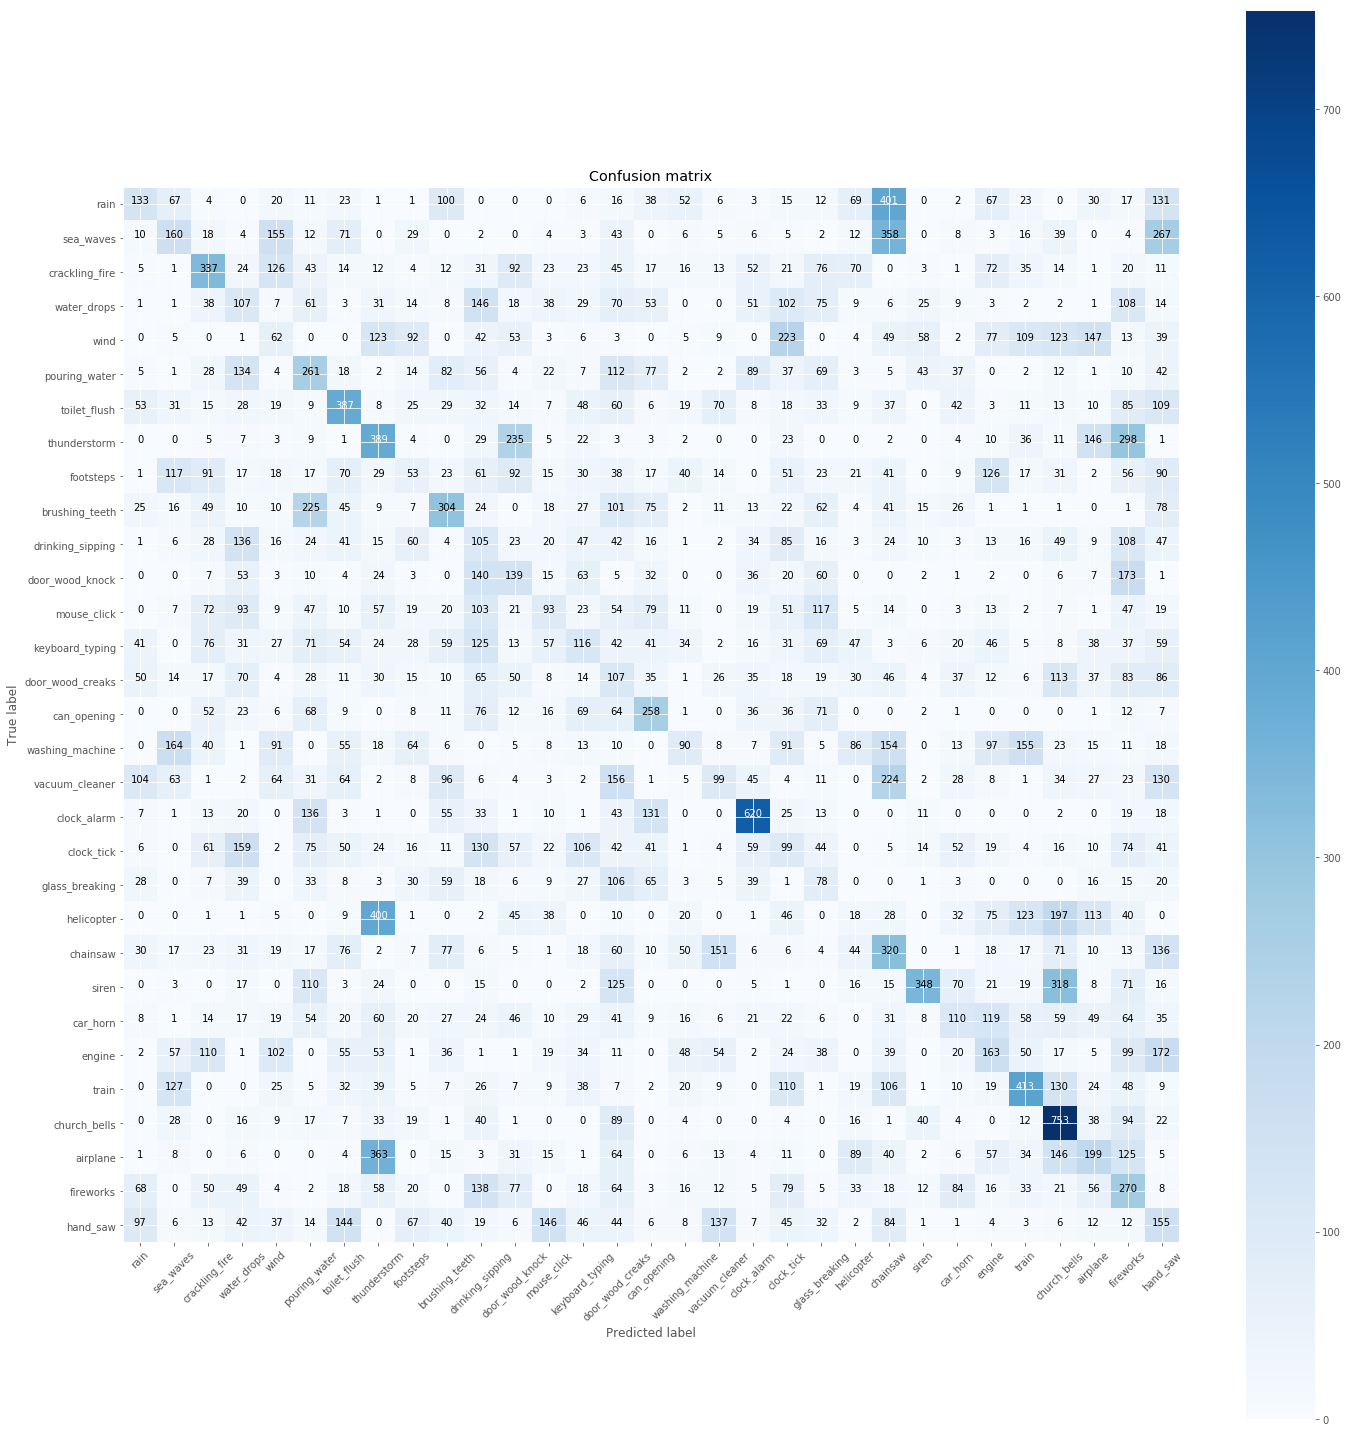

In [51]:
pred = inter.predict(new_dat)
print(metrics.accuracy_score(i_targ, pred))
cm = metrics.confusion_matrix(i_targ, pred)
plt.figure(figsize=(20,20))
plot_confusion_matrix(cm, names_i)
plt.show()